# Notebook [number]: Hopfield Models and Restricted Boltzmann Machines 

## Setting up the notebook
We will use an open-source python package for unsupervised learning called [paysage](https://github.com/drckf/paysage). Paysage requires python >3.5; we recommend the [Anaconda](https://www.continuum.io/downloads) environment.

To install paysage with pip in an Anaconda3 environment:

`pip install paysage`

Look at the github repo (linked above) for mode details.

By default, computations are performed using numpy/numexpr/numba on the CPU. If you have installed [PyTorch](https://pytorch.org), then you can switch to the pytorch backend by changing the setting in `paysage/backends/config.json` to `pytorch`. 

Let's set up the environment by importing paysage and defining some functions that are useful for visualizing the data.

In [1]:
import os, paysage, numpy
# set a random seed to ensure deterministic behavior
paysage.backends.set_seed(137)

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.cm as cm
import seaborn as sns

# make sure the plots are shown in the notebook

def plot_image_grid(image_array, shape, vmin=0, vmax=1, cmap=cm.gray_r, row_titles=None):
    array = paysage.backends.to_numpy_array(image_array)
    nrows, ncols = array.shape[:-1]
    f = plt.figure(figsize=(2*ncols, 2*nrows))
    grid = gs.GridSpec(nrows, ncols)
    axes = [[plt.subplot(grid[i,j]) for j in range(ncols)] for i in range(nrows)]
    for i in range(nrows):
        for j in range(ncols):
            sns.heatmap(numpy.reshape(array[i][j], shape),
                ax=axes[i][j], cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)
            axes[i][j].set(yticks=[])
            axes[i][j].set(xticks=[])

    if row_titles is not None:
        for i in range(nrows):
            axes[i][0].set_ylabel(row_titles[i], fontsize=18)
            
    plt.tight_layout()
    plt.show(f)
    plt.close(f)

## Obtaining the MNIST dataset

We will use the MNIST dataset of handwritten digits for our example. This dataset can be fetched from web as an HDF5 file by running `python3 mnist/download_mnist.py` in `paysage`. This file contains keys `train/images`, `train/labels`, `test/images`, and `test/labels` and is compressed to about 15 Mb in size.

As our first step, we will set up the paths to the data and shuffle the dataset. The shuffled dataset will not be compressed (for faster reading during training) so it will be about 56 Mb in size.

Why shuffle the data? Training with stochastic gradient descent means we will be using small minibatches of data (maybe 50 examples) to compute the gradient at each step. If the data have an order, then the estimates for the gradients computed from the minibatches will be biased. Shuffling the data ensures that the gradient estimates are unbiased (though still noisy).

In [2]:
paysage_path = os.path.dirname(os.path.dirname(paysage.__file__))
mnist_path = os.path.join(paysage_path, "mnist", "mnist.h5")
shuffled_mnist_path = os.path.join(paysage_path, "mnist", "shuffled_mnist.h5")

if not os.path.exists(mnist_path):
    raise IOError("{} does not exist. run mnist/download_mnist.py to fetch from the web".format(mnist_path))
    
if not os.path.exists(shuffled_mnist_path):
    paysage.batch.DataShuffler(mnist_path, shuffled_mnist_path, complevel=0).shuffle()

## Choosing the model hyperparameters

We need to set up the parameters of the model, such as the number of hidden units, and the hyperparameters of the training procedure. For the sake of this example, we will use 200 hidden units. Try increasing/decreasing the number of hidden units to see how the performance of the model changes.

In [3]:
num_hidden_units = 200
batch_size = 100
num_epochs = 20
monte_carlo_steps = 1
image_shape = (28, 28)
num_to_plot = 8

## Examples from MNIST

Let's plot a couple of random examples to get a look at the data.

We can set up generator to read data from the file in minibatches, while setting aside part of the data as a validation set to test how well the model describes the data. The greyscale images will be binarized as they are read.

In [4]:
print(mnist_path)
data = paysage.batch.HDFBatch(shuffled_mnist_path, 'train/images', batch_size,
                           transform=paysage.preprocess.binarize_color, train_fraction=0.95)

/Users/charlesfisher/Desktop/contrastive_divergence/paysage/mnist/mnist.h5


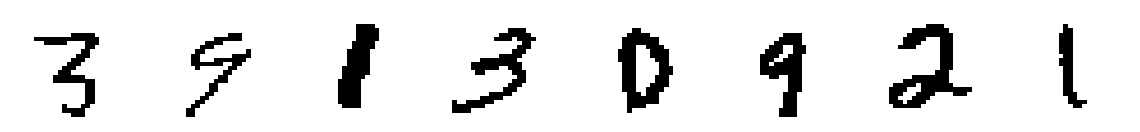

In [5]:
examples = data.get(mode='train') # shape (batch_size, 784)
data.reset_generator(mode='train') # reset the generator to the beginning of the file
example_plot = plot_image_grid(numpy.expand_dims(examples[:num_to_plot], 0), image_shape, vmin=0, vmax=1)

## The Hopfield Model

The Hopfield model is a model of associative memory with a layer of binary visible units connected to a layer of Gaussian hidden units. The joint energy of the model is:

$$
E( \boldsymbol{v}, \boldsymbol{h}) = - \sum_i a_i v_i + \frac{1}{2} \sum_j h_j^2 - \sum_{ij} W_{ij} v_i h_j
$$

The usual formulation of the Hopfield model can be obtained by integrating over the hidden units:

$$
E( \boldsymbol{v}) = - \log \int d \boldsymbol{h} e^{-E( \boldsymbol{v}, \boldsymbol{h}) } = - \sum_i a_i v_i - \frac{1}{2} \sum_{ij} \sum_k W_{ik} W_{kj} v_i h_j
$$

Training the model with 10 hidden units takes a little over 1 minute on a Macbook Pro laptoop with a 2.6 GHz Intel Core i5 and 8 GB 1600 MHz DDR3.

In [6]:
# set up the model
hopfield = paysage.models.model.Model([
    paysage.layers.BernoulliLayer(data.ncols),
    paysage.layers.GaussianLayer(num_hidden_units)
])

# the mean and standard deviation parameters of the hidden layer are unnecessary
# we will fix them to 0 and 1, respectively
hopfield.layers[1].set_fixed_params(['loc', 'log_var'])

# make a simple guess for the initial parameters of the model
hopfield.initialize(data, method='glorot_normal') 

# monitor the progress of some performance metrics during training
# the reconstruction error will be computed from the validation set
perf = paysage.fit.ProgressMonitor(data, metrics=['ReconstructionError'])

# set up an optimizer method (ADAM in this case)
learning_rate = paysage.schedules.PowerLawDecay(initial=2e-3, coefficient=1)
opt = paysage.optimizers.ADAM(stepsize=learning_rate)

# set up a Monte Carlo sampler
sampler = paysage.fit.SequentialMC.from_batch(hopfield, data)

# use persistent contrastive divergence to fit the Hopfield model
trainer = paysage.fit.SGD(hopfield, data, opt, num_epochs, sampler, method=paysage.fit.pcd, 
                     mcsteps=monte_carlo_steps, monitor=perf)
trainer.train()

End of epoch 0: 
-ReconstructionError: 8.728096
Epoch took 10.23 seconds

End of epoch 1: 
-ReconstructionError: 7.969023
Epoch took 10.11 seconds

End of epoch 2: 
-ReconstructionError: 7.740564
Epoch took 10.07 seconds

End of epoch 3: 
-ReconstructionError: 7.446699
Epoch took 10.16 seconds

End of epoch 4: 
-ReconstructionError: 7.369758
Epoch took 10.09 seconds

End of epoch 5: 
-ReconstructionError: 7.110040
Epoch took 10.07 seconds

End of epoch 6: 
-ReconstructionError: 7.055282
Epoch took 10.08 seconds

End of epoch 7: 
-ReconstructionError: 6.986010
Epoch took 10.08 seconds

End of epoch 8: 
-ReconstructionError: 6.883458
Epoch took 10.15 seconds

End of epoch 9: 
-ReconstructionError: 6.809821
Epoch took 10.10 seconds

End of epoch 10: 
-ReconstructionError: 6.688722
Epoch took 10.11 seconds

End of epoch 11: 
-ReconstructionError: 6.687850
Epoch took 10.12 seconds

End of epoch 12: 
-ReconstructionError: 6.629203
Epoch took 10.12 seconds

End of epoch 13: 
-ReconstructionEr

## The Restricted Boltzmann Machine (RBM)

The Restricted Boltzmann Machine is a model with a layer of binary visible units connected to a layer of binary hidden units. The joint energy of the model is:

$$
E( \boldsymbol{v}, \boldsymbol{h}) = - \sum_i a_i v_i - \sum_j b_j h_j - \sum_{ij} W_{ij} v_i h_j
$$

Training the model with 10 hidden units takes a little over 1 minute on a Macbook Pro laptoop with a 2.6 GHz Intel Core i5 and 8 GB 1600 MHz DDR3.

In [7]:
# set up the model
rbm = paysage.models.model.Model([
    paysage.layers.BernoulliLayer(data.ncols), 
    paysage.layers.BernoulliLayer(num_hidden_units)
])

# make a simple guess for the initial parameters of the model
rbm.initialize(data, method='glorot_normal') 

# monitor the progress of some performance metrics during training
# the reconstruction error will be computed from the validation set
perf = paysage.fit.ProgressMonitor(data, metrics= ['ReconstructionError'])

# set up an optimizer method (ADAM in this case)
learning_rate = paysage.schedules.PowerLawDecay(initial=1e-2, coefficient=1)
opt = paysage.optimizers.ADAM(stepsize=learning_rate)

# set up a Monte Carlo sampler
sampler = paysage.fit.SequentialMC.from_batch(rbm, data)

# use persistent contrastive divergence to fit the RBM
trainer = paysage.fit.SGD(rbm, data, opt, num_epochs, sampler, method=paysage.fit.pcd, 
                     mcsteps=monte_carlo_steps, monitor=perf)
trainer.train()

End of epoch 0: 
-ReconstructionError: 8.986861
Epoch took 8.89 seconds

End of epoch 1: 
-ReconstructionError: 8.555291
Epoch took 8.12 seconds

End of epoch 2: 
-ReconstructionError: 8.170985
Epoch took 8.08 seconds

End of epoch 3: 
-ReconstructionError: 7.944264
Epoch took 8.09 seconds

End of epoch 4: 
-ReconstructionError: 7.722197
Epoch took 8.08 seconds

End of epoch 5: 
-ReconstructionError: 7.633064
Epoch took 8.09 seconds

End of epoch 6: 
-ReconstructionError: 7.390444
Epoch took 8.07 seconds

End of epoch 7: 
-ReconstructionError: 7.323979
Epoch took 8.08 seconds

End of epoch 8: 
-ReconstructionError: 7.340254
Epoch took 8.19 seconds

End of epoch 9: 
-ReconstructionError: 7.185332
Epoch took 8.11 seconds

End of epoch 10: 
-ReconstructionError: 7.064088
Epoch took 8.10 seconds

End of epoch 11: 
-ReconstructionError: 6.991304
Epoch took 8.10 seconds

End of epoch 12: 
-ReconstructionError: 6.911802
Epoch took 8.11 seconds

End of epoch 13: 
-ReconstructionError: 6.927578

## An RBM with Sparse Weights

Often, it is helpful to add a term to the objective function that penalizes large weight values. It doesn't make a lot of difference for a model with just 10 hidden units, but for larger models regularization may help improve generalization outside of the training data. 

Here, we will use an L1 penalty:

$$
f_{\lambda}(\boldsymbol{W}) = \lambda \sum_{ij} |W_{ij}| 
$$

The L1 penalty helps to encourage sparsity by setting $W_{ij} \approx 0$.

In [8]:
# set up the model
rbmL1 = paysage.models.model.Model([
    paysage.layers.BernoulliLayer(data.ncols), 
    paysage.layers.BernoulliLayer(num_hidden_units)
])

# add an l1 penalty to the weights
rbmL1.weights[0].add_penalty({'matrix': paysage.penalties.l1_penalty(1e-3)})

# make a simple guess for the initial parameters of the model
rbmL1.initialize(data, method='glorot_normal') 

# monitor the progress of some performance metrics during training
# the reconstruction error will be computed from the validation set
perf = paysage.fit.ProgressMonitor(data, metrics=['ReconstructionError'])

# set up an optimizer method (ADAM in this case)
learning_rate = paysage.schedules.PowerLawDecay(initial=1e-2, coefficient=1)
opt = paysage.optimizers.ADAM(stepsize=learning_rate)

# set up a Monte Carlo sampler
sampler = paysage.fit.SequentialMC.from_batch(rbmL1, data)

# use persistent contrastive divergence to fit the RBM
trainer = paysage.fit.SGD(rbmL1, data, opt, num_epochs, sampler, method=paysage.fit.pcd, 
                     mcsteps=monte_carlo_steps, monitor=perf)
trainer.train()

End of epoch 0: 
-ReconstructionError: 9.103497
Epoch took 8.60 seconds

End of epoch 1: 
-ReconstructionError: 8.708616
Epoch took 8.61 seconds

End of epoch 2: 
-ReconstructionError: 8.477873
Epoch took 8.69 seconds

End of epoch 3: 
-ReconstructionError: 8.159310
Epoch took 8.66 seconds

End of epoch 4: 
-ReconstructionError: 7.978847
Epoch took 8.65 seconds

End of epoch 5: 
-ReconstructionError: 7.729209
Epoch took 8.63 seconds

End of epoch 6: 
-ReconstructionError: 7.661331
Epoch took 8.63 seconds

End of epoch 7: 
-ReconstructionError: 7.558946
Epoch took 8.62 seconds

End of epoch 8: 
-ReconstructionError: 7.481622
Epoch took 8.62 seconds

End of epoch 9: 
-ReconstructionError: 7.355316
Epoch took 8.62 seconds

End of epoch 10: 
-ReconstructionError: 7.281850
Epoch took 8.62 seconds

End of epoch 11: 
-ReconstructionError: 7.315509
Epoch took 8.62 seconds

End of epoch 12: 
-ReconstructionError: 7.102793
Epoch took 8.63 seconds

End of epoch 13: 
-ReconstructionError: 7.112032

## Layerwise Training of a Deep Boltzmann Machine

Deep Boltzmann Machines are difficult to train end-to-end. However, it is possible to pre-train a DBM using a layerwise approach outlined in:

Salakhutdinov, Ruslan, and Geoffrey Hinton. "Deep boltzmann machines." Artificial Intelligence and Statistics. 2009.

In [9]:
# set up the model
dbm = paysage.models.model.Model([
    paysage.layers.BernoulliLayer(data.ncols), 
    paysage.layers.BernoulliLayer(num_hidden_units),
    paysage.layers.BernoulliLayer(num_hidden_units)
])

# add an l1 penalty to the weights
for weight in dbm.weights:
    weight.add_penalty({'matrix': paysage.penalties.l1_penalty(1e-3)})

# make a simple guess for the initial parameters of the model
dbm.initialize(data, method='glorot_normal') 

# layerwise pre-training
learning_rate = paysage.schedules.PowerLawDecay(initial=1e-2, coefficient=1)
opt = paysage.optimizers.ADAM(stepsize=learning_rate)
pretrainer = paysage.fit.LayerwisePretrain(dbm, data, opt, num_epochs, method=paysage.fit.pcd,
                 mcsteps=monte_carlo_steps, metrics=['ReconstructionError'])
pretrainer.train()

# fine-tuning by persistent contrastive divergence
perf = paysage.fit.ProgressMonitor(data, metrics= ['ReconstructionError'])
learning_rate = paysage.schedules.PowerLawDecay(initial=1e-3, coefficient=1)
opt = paysage.optimizers.ADAM(stepsize=learning_rate)
sampler = paysage.fit.SequentialMC.from_batch(dbm, data)
trainer = paysage.fit.SGD(dbm, data, opt, num_epochs, sampler, method=paysage.fit.pcd, 
                     mcsteps=monte_carlo_steps, monitor=perf)
trainer.train()

training model 0

End of epoch 0: 
-ReconstructionError: 8.505332
Epoch took 13.80 seconds

End of epoch 1: 
-ReconstructionError: 7.861170
Epoch took 13.86 seconds

End of epoch 2: 
-ReconstructionError: 7.506775
Epoch took 13.30 seconds

End of epoch 3: 
-ReconstructionError: 7.359846
Epoch took 13.57 seconds

End of epoch 4: 
-ReconstructionError: 7.108704
Epoch took 13.97 seconds

End of epoch 5: 
-ReconstructionError: 6.983313
Epoch took 13.36 seconds

End of epoch 6: 
-ReconstructionError: 6.855630
Epoch took 10.44 seconds

End of epoch 7: 
-ReconstructionError: 6.813149
Epoch took 8.82 seconds

End of epoch 8: 
-ReconstructionError: 6.714388
Epoch took 8.79 seconds

End of epoch 9: 
-ReconstructionError: 6.617905
Epoch took 8.77 seconds

End of epoch 10: 
-ReconstructionError: 6.565871
Epoch took 8.78 seconds

End of epoch 11: 
-ReconstructionError: 6.437002
Epoch took 8.78 seconds

End of epoch 12: 
-ReconstructionError: 6.356571
Epoch took 8.95 seconds

End of epoch 13: 
-Reco

# Visualizations

To compare the models, we will visualize some reconstructions and some samples drawn from the model using Markov Chain Monte Carlo (these are called fantasy particles).

In [10]:
def compute_reconstructions(rbm, data):
    """
    Computes reconstructions of the input data.
    Input v -> h -> v'
    
    Args:
        rbm: a model
        data: a tensor of shape (num_samples, num_visible_units)
        
    Returns:
        tensor of shape (num_samples, num_visible_units)
    
    """
    sampler = paysage.fit.SequentialMC(rbm)
    data_state = paysage.models.model_utils.State.from_visible(data, rbm)
    sampler.set_state(data_state)
    model = rbm.deterministic_iteration(rbm.num_weights, sampler.state).units[0]
    return paysage.backends.to_numpy_array(model)

def compute_fantasy_particles(rbm, data, num_steps, mean_field=True):
    """
    Draws samples from the model using Gibbs sampling Markov Chain Monte Carlo .
    Starts from randomly initialized points. 
    
    Args:
        rbm: a model
        data: a tensor of shape (num_samples, num_visible_units)
        num_steps (int): the number of update steps
        mean_field (bool; optional): run a final mean field step to compute probabilities
        
    Returns:
        tensor of shape (num_samples, num_visible_units)
    
    """
    random_samples = rbm.random(data)
    model_state = paysage.models.model_utils.State.from_visible(random_samples, rbm)
    sampler = paysage.fit.SequentialMC(rbm)
    sampler.set_state(model_state)
    sampler.update_state(num_steps)
    if mean_field:
        model = rbm.mean_field_iteration(rbm.num_weights, sampler.state).units[0]
    else:
        model = sampler.state.units[0]
    return paysage.backends.to_numpy_array(model)

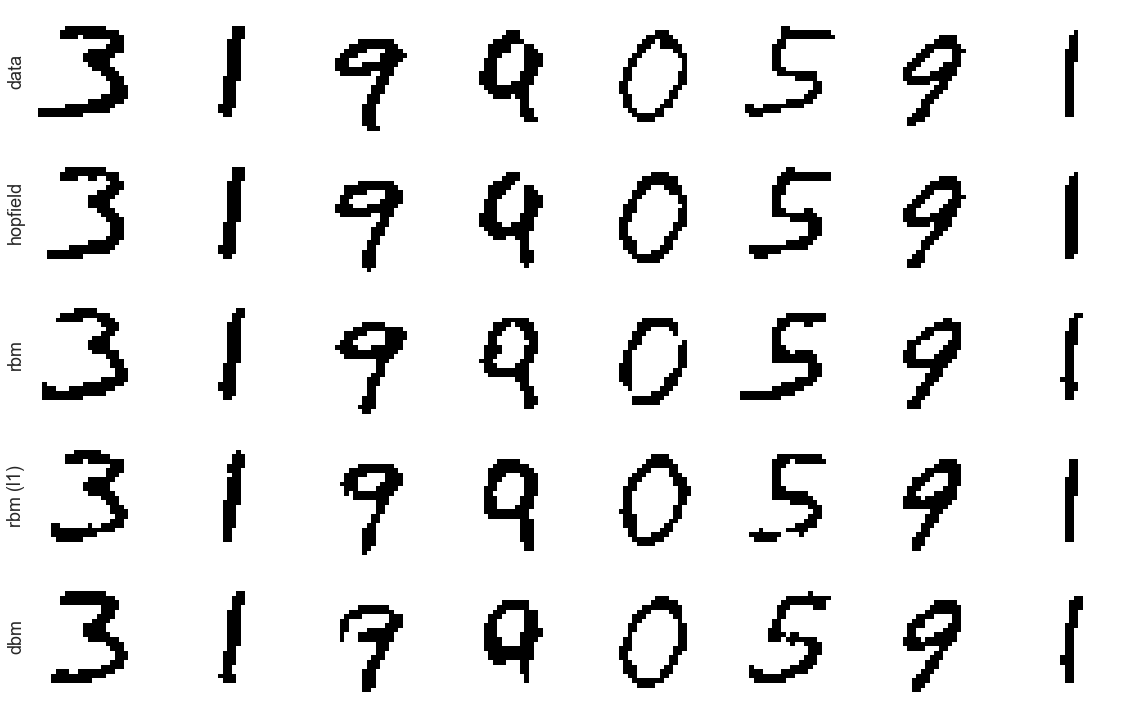

In [11]:
examples = data.get(mode='validate') # shape (batch_size, 784)
data.reset_generator(mode='validate') # reset the generator to the beginning of the validation set

hopfield_reconstructions = compute_reconstructions(hopfield, examples[:num_to_plot])
rbm_reconstructions = compute_reconstructions(rbm, examples[:num_to_plot])
rbmL1_reconstructions = compute_reconstructions(rbmL1, examples[:num_to_plot])
dbm_reconstructions = compute_reconstructions(dbm, examples[:num_to_plot])

reconstruction_plot = plot_image_grid(
    numpy.array([examples[:num_to_plot], 
                 hopfield_reconstructions, 
                 rbm_reconstructions, 
                 rbmL1_reconstructions,
                 dbm_reconstructions]), 
    image_shape, vmin=0, vmax=1, row_titles=["data", "hopfield", "rbm", "rbm (l1)", "dbm"])

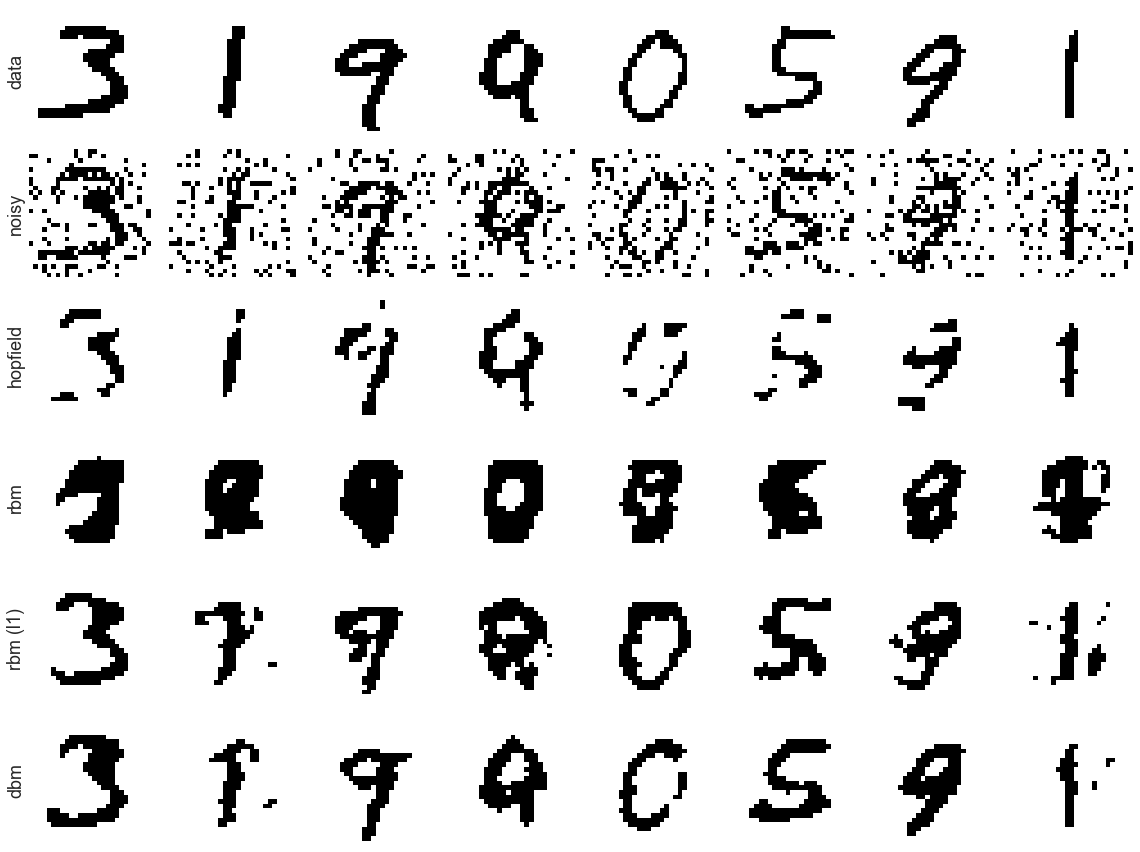

In [12]:
examples = data.get(mode='validate') # shape (batch_size, 784)
data.reset_generator(mode='validate') # reset the generator to the beginning of the validation set

# add some noise to the examples by randomly flipping some pixels 0 -> 1 and 1 -> 0
fraction_to_flip = 0.15
flip_mask = paysage.backends.rand_like(examples) < fraction_to_flip
noisy = (1-flip_mask) * examples + flip_mask * (1 - examples)

hopfield_denoised = compute_reconstructions(hopfield, noisy[:num_to_plot])
rbm_denoised = compute_reconstructions(rbm, noisy[:num_to_plot])
rbmL1_denoised = compute_reconstructions(rbmL1, noisy[:num_to_plot])
dbm_denoised = compute_reconstructions(dbm, noisy[:num_to_plot])

denoising_plot = plot_image_grid(
    numpy.array([examples[:num_to_plot], 
                 noisy[:num_to_plot], 
                 hopfield_denoised, 
                 rbm_denoised, 
                 rbmL1_denoised,
                 dbm_denoised]), 
    image_shape, vmin=0, vmax=1, row_titles=["data", "noisy", "hopfield", "rbm", "rbm (l1)", "dbm"])

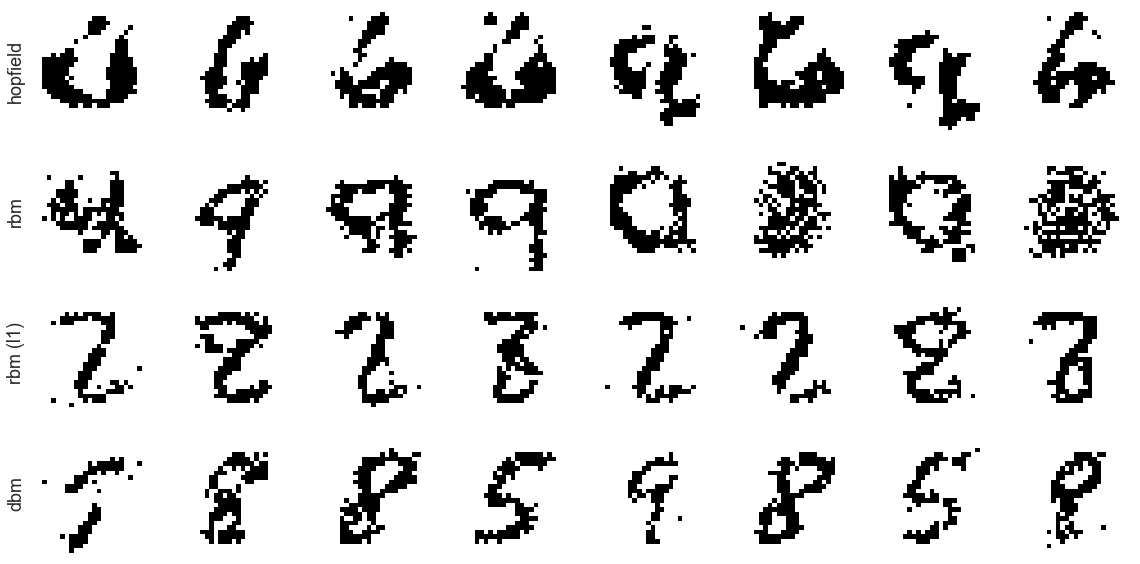

In [13]:
examples = data.get(mode='validate') # shape (batch_size, 784)
data.reset_generator(mode='validate') # reset the generator to the beginning of the validation set

hopfield_fantasy = compute_fantasy_particles(hopfield, examples[:num_to_plot], 100, mean_field=False)
rbm_fantasy = compute_fantasy_particles(rbm, examples[:num_to_plot], 100, mean_field=False)
rbmL1_fantasy = compute_fantasy_particles(rbmL1, examples[:num_to_plot], 100, mean_field=False)
dbm_fantasy = compute_fantasy_particles(dbm, examples[:num_to_plot], 100, mean_field=False)

fantasy_plot = plot_image_grid(
    numpy.array([hopfield_fantasy, 
                 rbm_fantasy, 
                 rbmL1_fantasy,
                 dbm_fantasy]), 
    image_shape, vmin=0, vmax=1, row_titles=["hopfield", "rbm", "rbm (l1)", "dbm"])

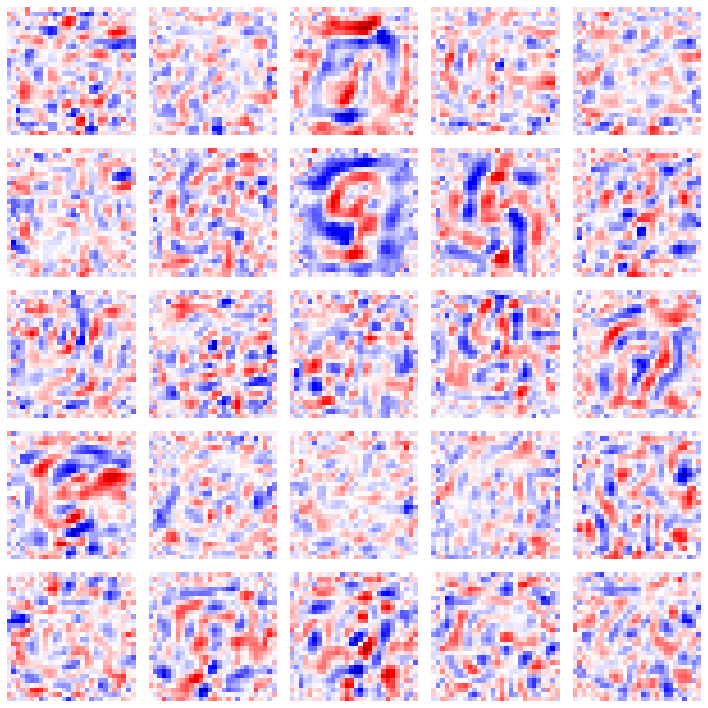

In [14]:
# plot the weights of the hopfield model
hopfield_weights = plot_image_grid(
    paysage.backends.reshape(hopfield.weights[0].W_T()[:25], (5,5,784)), 
    image_shape, 
    vmin=paysage.backends.tmin(hopfield.weights[0].W()), 
    vmax=paysage.backends.tmax(hopfield.weights[0].W()),
    cmap=cm.seismic)

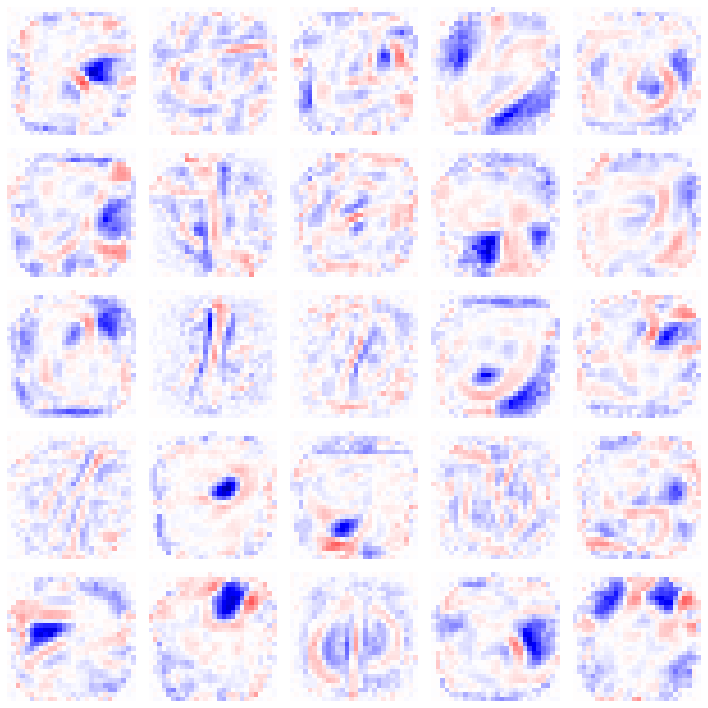

In [15]:
# plot the weights of the RBM
rbm_weights = plot_image_grid(
    paysage.backends.reshape(rbm.weights[0].W_T()[:25], (5,5,784)), 
    image_shape, 
    vmin=paysage.backends.tmin(rbm.weights[0].W()), 
    vmax=paysage.backends.tmax(rbm.weights[0].W()),
    cmap=cm.seismic)

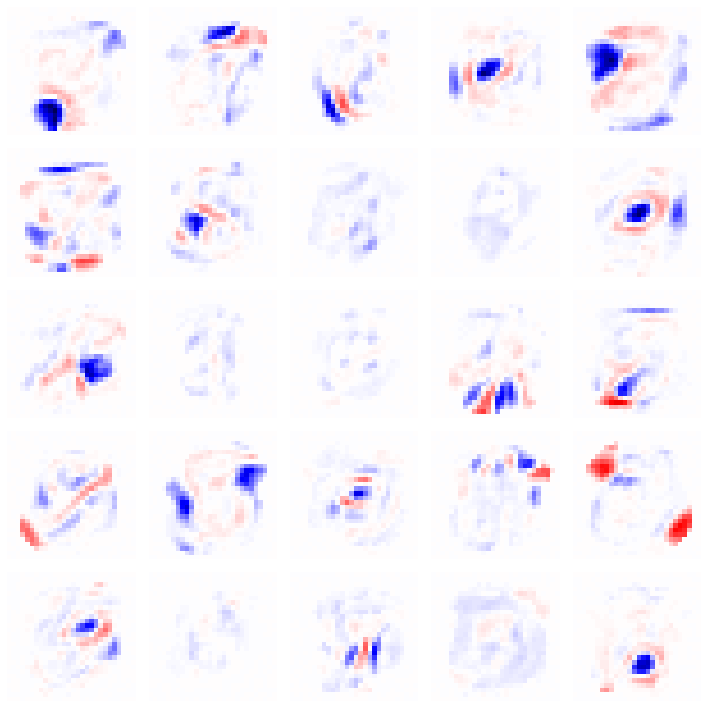

In [16]:
# plot the weights of the L1 regularized RBM
rbmL1_weights = plot_image_grid(
    paysage.backends.reshape(rbmL1.weights[0].W_T()[:25], (5,5,784)), 
    image_shape, 
    vmin=paysage.backends.tmin(rbmL1.weights[0].W()), 
    vmax=paysage.backends.tmax(rbmL1.weights[0].W()),
    cmap=cm.seismic)

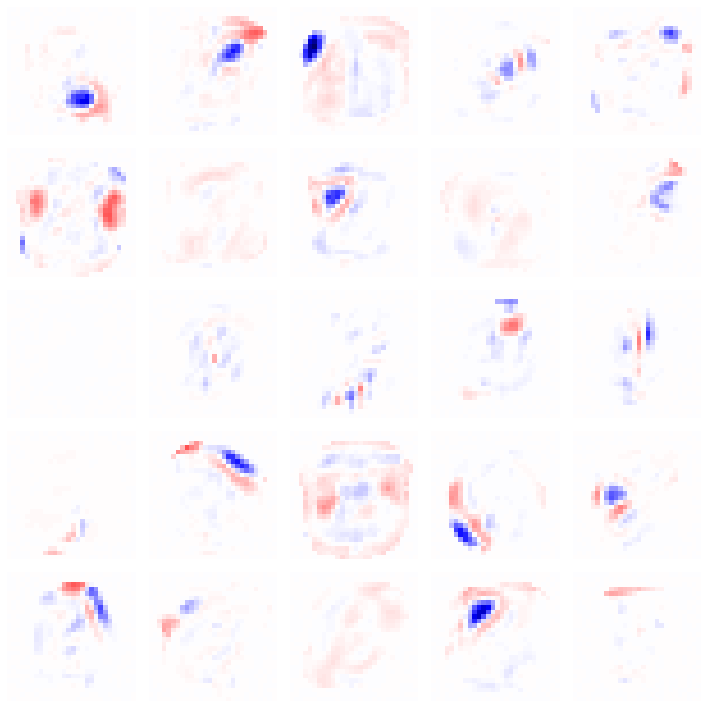

In [17]:
# plot the weights of the first layer of the dbm
dbm_weights = plot_image_grid(
    paysage.backends.reshape(dbm.weights[0].W_T()[:25], (5,5,784)), 
    image_shape, 
    vmin=paysage.backends.tmin(dbm.weights[0].W()), 
    vmax=paysage.backends.tmax(dbm.weights[0].W()),
    cmap=cm.seismic)

In [18]:
data.close() # close the HDF5 store with the MNIST dataset